In [9]:
import os                                                                          
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"                                       
os.environ["CUDA_VISIBLE_DEVICES"]="1"                                             
import tensorflow as tf                                                            
session_config=tf.ConfigProto(                                                     
        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9, allow_growth=True), allow_soft_placement=True, log_device_placement=False)
sess = tf.Session(config=session_config)  

In [10]:
import keras
import pickle
from skimage import io, transform
import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

import keras.backend as K
from keras import layers, Model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, BatchNormalization, Activation, ZeroPadding2D, \
Conv2DTranspose, UpSampling2D, Input, GlobalMaxPool2D

# Make dataset 

In [11]:
# address = '/all/media/hdd1/georgy'
# def fix_address(adr):
#     fix_adr = list(adr)
#     fix_adr[0]=address
#     fix_adr=''.join(fix_adr)
#     return fix_adr
# with open('/all/media/hdd1/georgy/checkpoints/CubeChangeClassName_v1.2_558b0595e105de8cad848fa41ae1bc87de6713ec62906783b57858e9.pkl','rb') as f:
#     data = pickle.load(f)

# patch_dir_name = 'patches'
# if not os.path.isdir(patch_dir_name):
#     os.makedirs(patch_dir_name)

# sizes = []
# for i, example in enumerate(data['data_description']):
#     image = io.imread(fix_address(example['image_path']))
#     for j, obj in enumerate(example['objects']):
#         x1,y1 = np.min(obj['polygons']['front'], axis=0).astype(int)
#         x2,y2 = np.max(obj['polygons']['front'],axis=0).astype(int)
#         patch = image[y1:y2,x1:x2].copy()
#         io.imsave(patch_dir_name + '/{}_{}.jpg'.format(i,j), patch)

# Make model 

## define loss pad and crop func 

In [12]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def padd_to_16fit(inputs):
    '''
    zero pad input tensor to shape multiple to 16
    '''
    shape = K.shape(inputs) #batch,h,w,channel
    inputs = K.switch(K.equal(shape[2]%32,0),
                            inputs,
                            tf.pad(inputs,((0,0), #batch
                                           (0,0), #h
                                           ((32-shape[2]%32)//2,(32-shape[2]%32)//2+(32-shape[2]%32)%2), #w
                                           (0,0)))) #channel
    inputs = K.switch(K.equal(shape[1]%32,0),
                            inputs,
                            tf.pad(inputs,((0,0),
                                          ((32-shape[1]%32)//2,(32-shape[1]%32)//2+(32-shape[1]%32)%2),
                                          (0,0),
                                          (0,0))))
    return inputs

def crop_to_16fit(arg):
    '''
    crop output tensor to initial shape (undo result of padd_to_16fit() )
    '''
    [conv10, inputs] = arg
    shape = K.shape(inputs) #batch,h,w,channel
    conv10 = tf.cond(K.equal(shape[1]%32,0),
                            lambda: conv10,
                            lambda: tf.slice(conv10,(0,(32-shape[1]%32)//2,0,0),
                                           (-1,shape[1],-1,-1)),
                    name = 'vertical_crop') 
    conv10 = tf.cond(K.equal(shape[2]%32,0),
                            lambda: conv10,
                            lambda: tf.slice(conv10,(0,0,(32-shape[2]%32)//2,0),
                                           (-1,-1,shape[2],-1)),
                    name = 'horizontal_crop')
    return conv10

def make_voluem(inputs):
    x_flatten, x_shaped = inputs
    shape = tf.shape(x_shaped)
    ones_voluem = tf.ones([shape[0], shape[1], shape[2], HIDDEN_DEPTH], tf.float32)
    return x_flatten*ones_voluem

## define  upsample layers

In [13]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'upsample_res' + str(stage) + block + '_branch'
    bn_name_base = 'upsample_bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([input_tensor, x])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'upsample_res' + str(stage) + block + '_branch'
    bn_name_base = 'upsample_bn' + str(stage) + block + '_branch'
    up_name_base = 'upsample_upsample' + str(stage) + block + '_branch'
    
    x = UpSampling2D(strides, name=up_name_base + '2a')(input_tensor)
    x = Conv2D(filters1, (1, 1), strides=(1, 1),
               name=conv_name_base + '2a')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
        
    shortcut = UpSampling2D(strides, name=up_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=(1, 1),
                      name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

##  set nontrainable layers

In [14]:
def set_trainable(model):
    for layer in model.layers:
        if not layer.name.startswith('upsample'):
            layer.trainable = False
    return model

## build model

In [15]:
HIDDEN_DEPTH = 10

inputs = keras.layers.Input((None, None, 3))
tf.assert_greater(tf.shape(inputs)[1], 192)
x = keras.layers.Lambda(padd_to_16fit, name='pad', output_shape=(None,None,3))(inputs)
resnet_backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=x, input_shape=None, pooling='max')
x_shaped = resnet_backbone.get_layer(index=-3).output
x = GlobalMaxPool2D()(x_shaped)
x = keras.layers.Dense(HIDDEN_DEPTH)(x)

x = keras.layers.Lambda(make_voluem)([x, x_shaped])

bn_axis = 3 # tf order
x = conv_block(x, 3, [512, 512, 512], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 512], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 512], stage=5, block='c')

x = conv_block(x, 3, [256, 256, 256], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 256], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 256], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 256], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 256], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 256], stage=4, block='f')    

x = conv_block(x, 3, [256, 128, 128], stage=3, block='a')
x = identity_block(x, 3, [256, 128, 128], stage=3, block='b')
x = identity_block(x, 3, [256, 128, 128], stage=3, block='c')
x = identity_block(x, 3, [256, 128, 128], stage=3, block='d')

x = conv_block(x, 3, [64, 64, 64], stage=2, block='a', strides=(2, 2))
x = identity_block(x, 3, [64, 64, 64], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 64], stage=2, block='c')

x = UpSampling2D((2,2), name = 'upsample_last_upsample')(x)
x = Conv2D(3, (3, 3), padding='same', name='upsample_conv1')(x)
x = BatchNormalization(axis=bn_axis, name='upsample_bn_conv1')(x)
x = Activation('tanh', name = 'upsample_final_activation')(x)

x = keras.layers.Lambda(crop_to_16fit, name='crop', output_shape=(None,None,3))([x, inputs])

model = Model(inputs=[inputs], outputs=[x])
model = set_trainable(model) # not train initial resnet
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])


In [16]:
input_image = io.imread('../patches/1001_0.jpg').astype(np.float)
input_image = preprocess_input(input_image, mode='tf')


In [17]:
input_image.shape

(236, 673, 3)

In [19]:
small_image = transform.rescale(input_image, scale = 0.1, order = 3)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
input_image = np.random.rand(31,197,3)

In [29]:
input_image.shape

(31, 197, 3)

In [30]:
model.fit(input_image[None,...],input_image[None,...],epochs=1)
pred = model.predict(input_image[None,...])

Epoch 1/1
1/1 [==============================] - 0s 133ms/step - loss: -0.0476 - dice_coef: 0.0476


In [31]:
pred.shape

(1, 31, 197, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


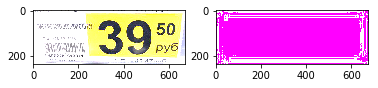

In [17]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(input_image - np.min(input_image))
ax2.imshow((pred[0]- np.min(pred[0]))/np.max(pred[0]))

In [ ]:
# input_image = np.random.randn(260,260,3)
# init_op = tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_op)
#     res = sess.run(x, feed_dict={inputs: [input_image]})

In [ ]:
model.summary()

# Data generator

In [18]:
import random
from skimage.transform import rescale
from skimage.io import imread
import os
import re

images_folder = '../patches/'
files_list = next(os.walk(images_folder))[2]

examples_num = len(files_list) 
random.seed(17)
random.shuffle(files_list)
train_set = files_list[:int(examples_num*0.97)]
train_num = len(train_set)
val_set = files_list[int(examples_num*0.97):]
val_num = len(val_set)

def data_generator(examples, batch_size=1): #examples is train or val
    while 1:
        random.shuffle(examples)
        images_batch = []
        batch_count = 0
        for file_name in examples:
            batch_count+=1
            image = imread(images_folder + file_name)
            image = image.astype(np.float32)
            image = preprocess_input(image, mode='tf')
            images_batch.append(image)
            if batch_count==batch_size:
                images_batch = np.array(images_batch) #TODO variable size images in batch
                yield images_batch, images_batch
                images_batch = []
                lables_batch = []
                batch_count=0

## make logdir

In [19]:
import os
log_dir = 'log/'
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
list_log_dir = os.listdir(log_dir)
if list_log_dir == []:
    log_dir = log_dir + '/0'
    os.makedirs(log_dir)
else:
    log_dir = log_dir+'/{}'.format(np.max([int(i) for i in list_log_dir])+1)
    os.makedirs(log_dir)

##  start learing

In [ ]:
from keras.callbacks import  TensorBoard
from  keras.callbacks import ModelCheckpoint
batch_size=1
model.fit_generator(generator=data_generator(train_set, batch_size),\
                    epochs=10,steps_per_epoch=train_num/batch_size,\
                    validation_data = data_generator(val_set, batch_size),\
                    validation_steps = val_num/batch_size,\
                    callbacks = [TensorBoard(log_dir = log_dir),\
                                 ModelCheckpoint(filepath = 'learned_model_{val_loss:.2f}.hdf5',\
                                                 save_best_only = True, monitor = 'val_dice_coef',mode='max')])

Epoch 1/10
    1/15299 [..............................] - ETA: 3:06:33 - loss: -0.0771 - dice_coef: 0.0771

In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(input_image - np.min(input_image))
ax2.imshow(res[0]- np.min(res[0]))

In [18]:
6*32

192